<a href="https://colab.research.google.com/github/lps5e/IA2S/blob/main/notebooks/SBCAS2025_EHMS2020_allClassifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset and install libraries



In [ ]:
!wget https://www.cse.wustl.edu/~jain/ehms/ftp/wustl-ehms-2020_with_attacks_categories.csv

--2025-02-01 14:24:45--  https://www.cse.wustl.edu/~jain/ehms/ftp/wustl-ehms-2020_with_attacks_categories.csv
Resolving www.cse.wustl.edu (www.cse.wustl.edu)... 128.252.167.136
Connecting to www.cse.wustl.edu (www.cse.wustl.edu)|128.252.167.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3946888 (3.8M) [text/csv]
Saving to: ‘wustl-ehms-2020_with_attacks_categories.csv’

wustl-ehms-2020_wit 100%[===================>]   3.76M  8.13MB/s    in 0.5s    

2025-02-01 14:24:46 (8.13 MB/s) - ‘wustl-ehms-2020_with_attacks_categories.csv’ saved [3946888/3946888]



In [ ]:
!pip install xgboost numpy shap scikit-learn matplotlib

# Load WUSTL-EHMS-2020 Dataset

In [ ]:
import pandas as pd

df = pd.read_csv('wustl-ehms-2020_with_attacks_categories.csv')

# Preprocessing the Dataset

In [ ]:
df['Attack Category'] = df['Attack Category'].replace('normal', 'Benign')

col_irrelevantes = ['SrcMac','Dir', 'Label', 'Flgs', 'Packet_num']
col_enderecos = ['Flgs', 'DstMac', 'SrcMac', 'SrcAddr', 'DstAddr', 'Sport']
col_biomedic = ['Temp', 'SpO2', 'Pulse_Rate', 'SYS', 'DIA', 'Heart_rate', 'Resp_Rate', 'ST']

df = df.drop(columns=col_irrelevantes)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder_AttackCategory = LabelEncoder()
df['Attack Category'] = label_encoder_AttackCategory.fit_transform(df['Attack Category'])

#label_encoder_Flgs = LabelEncoder()
#df['Flgs'] = label_encoder_Flgs.fit_transform(df['Flgs'])

label_encoder_DstMac = LabelEncoder()
df['DstMac'] = label_encoder_DstMac.fit_transform(df['DstMac'])

#label_encoder_SrcMac = LabelEncoder()
#df['SrcMac'] = label_encoder_SrcMac.fit_transform(df['SrcMac'])

label_encoder_SrcAddr = LabelEncoder()
df['SrcAddr'] = label_encoder_SrcAddr.fit_transform(df['SrcAddr'])

label_encoder_DstAddr = LabelEncoder()
df['DstAddr'] = label_encoder_DstAddr.fit_transform(df['DstAddr'])

label_encoder_Sport = LabelEncoder()
df['Sport'] = label_encoder_Sport.fit_transform(df['Sport'])

df= df.drop(index=10633)
df= df.drop(index=7923)
df= df.drop(index=8412)

# Split, Train and Normalize the Dataset

In [ ]:
X = df.drop(columns=['Attack Category'])
y = df['Attack Category']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_trainN = scaler.fit_transform(X_train)
X_testN = scaler.transform(X_test)

X_trainN = pd.DataFrame(X_trainN, columns = X_train.columns)
X_testN = pd.DataFrame(X_testN, columns = X_test.columns)

from sklearn.metrics import classification_report
class_names = ['Benign', 'Data Alteration', 'Spoofing']

# Generate Classification Report with Packet_num and Biomedic features

### XGB Classifier

In [ ]:
import xgboost as xgb
modelXGB = xgb.XGBClassifier(objective="binary:logistic")
modelXGB.fit(X_trainN, y_train)

y_predXGB = modelXGB.predict(X_testN)
print(classification_report(y_test, y_predXGB, target_names=class_names))

                 precision    recall  f1-score   support

         Benign       0.98      0.99      0.99      2827
Data Alteration       0.99      0.99      0.99       196
       Spoofing       0.92      0.72      0.81       240

       accuracy                           0.97      3263
      macro avg       0.96      0.90      0.93      3263
   weighted avg       0.97      0.97      0.97      3263



### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
modelRF = RandomForestClassifier(random_state=42, n_estimators=100)
modelRF.fit(X_trainN, y_train)

y_predRF = modelRF.predict(X_testN)
print(classification_report(y_test, y_predRF, target_names=class_names))

                 precision    recall  f1-score   support

         Benign       0.93      1.00      0.96      2827
Data Alteration       1.00      0.99      0.99       196
       Spoofing       0.75      0.07      0.14       240

       accuracy                           0.93      3263
      macro avg       0.89      0.69      0.70      3263
   weighted avg       0.92      0.93      0.90      3263



### Support Vector Machines Classifier

In [ ]:
from sklearn import svm
modelSVM = svm.SVC(probability=True)
modelSVM.fit(X_trainN, y_train)

y_predSVM = modelSVM.predict(X_testN)
print(classification_report(y_test, y_predSVM, target_names=class_names))

                 precision    recall  f1-score   support

         Benign       0.92      1.00      0.96      2827
Data Alteration       0.99      0.99      0.99       196
       Spoofing       1.00      0.01      0.02       240

       accuracy                           0.93      3263
      macro avg       0.97      0.67      0.66      3263
   weighted avg       0.93      0.93      0.89      3263



# Generate SHAP values and create Plots

### XGB Plots

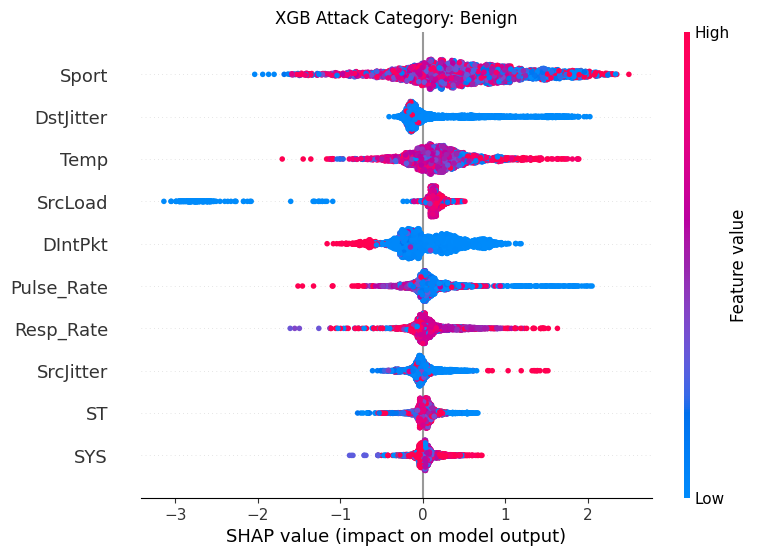

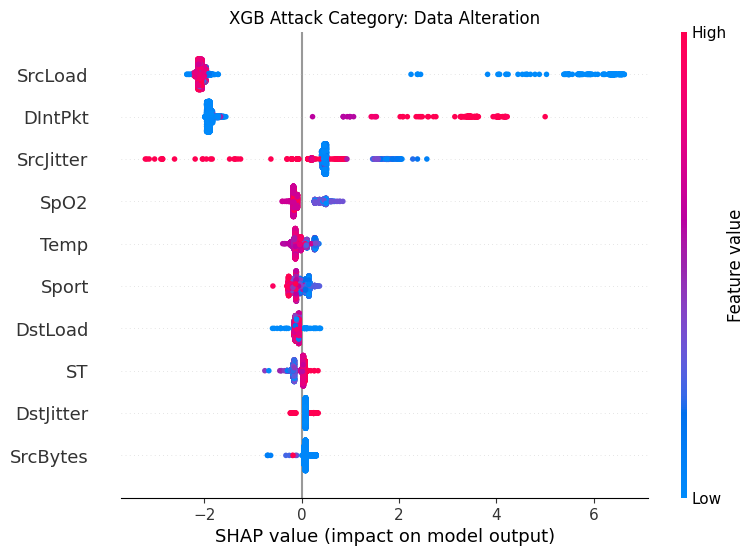

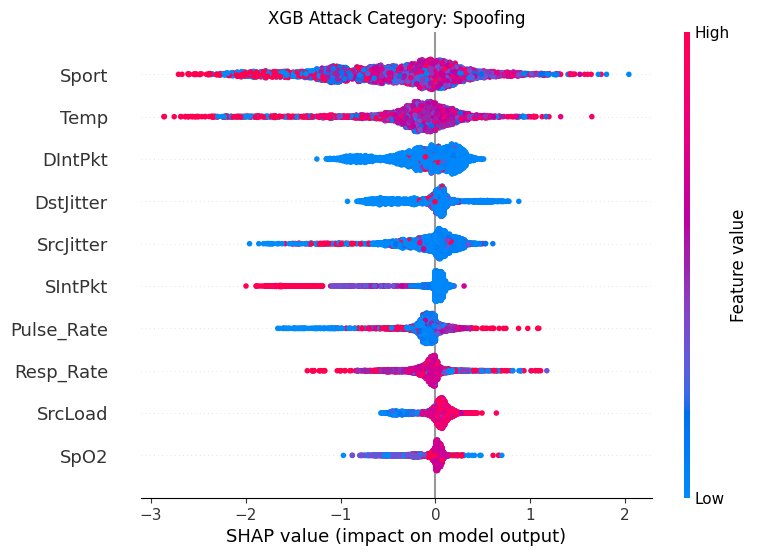

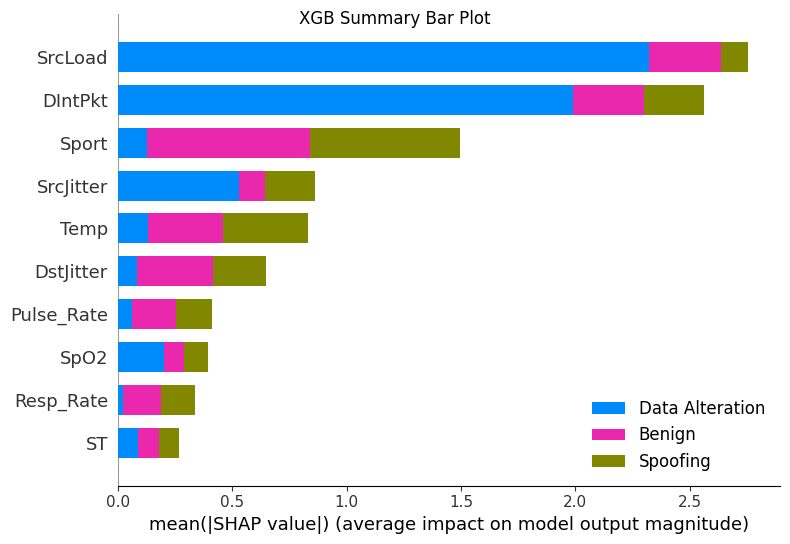

In [ ]:
import shap
explainerXGB = shap.Explainer(modelXGB)
shap_valuesXGB = explainerXGB.shap_values(X_testN)

import matplotlib.pyplot as plt
shap.summary_plot(shap_valuesXGB[:, :, 0], X_test, show = False, max_display=10)
plt.title("XGB Attack Category: Benign")
plt.show()

shap.summary_plot(shap_valuesXGB[:, :, 1], X_test, show = False, max_display=10)
plt.title("XGB Attack Category: Data Alteration")
plt.show()

shap.summary_plot(shap_valuesXGB[:, :, 2], X_test, show = False, max_display=10)
plt.title("XGB Attack Category: Spoofing")
plt.show()

def shap_values_to_list(shap_valuesXGB, model):
    shap_as_list=[]
    for i in range(len(model.classes_)):
        shap_as_list.append(shap_valuesXGB[:,:,i])
    return shap_as_list

shap_as_list = shap_values_to_list(shap_valuesXGB, modelXGB)
shap.summary_plot(shap_as_list, X_test, plot_type="bar", class_names=['Benign', 'Data Alteration', 'Spoofing'], show = False, max_display=10)
plt.suptitle("XGB Summary Bar Plot")
plt.show()

### RF Plots

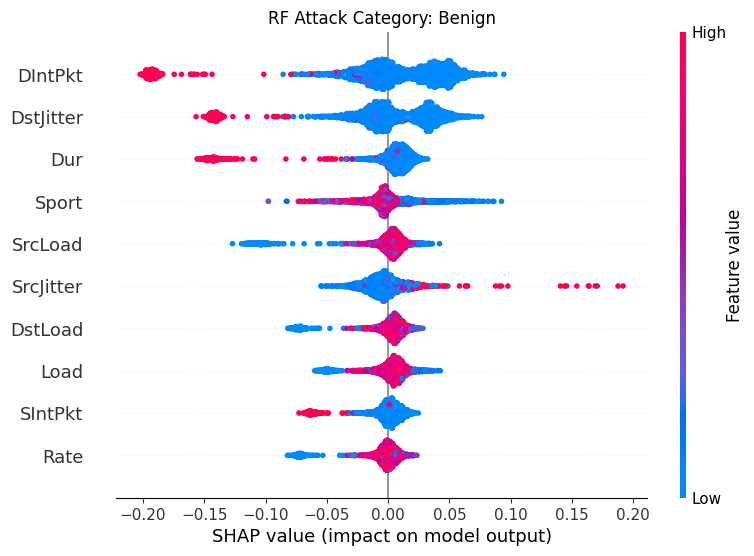

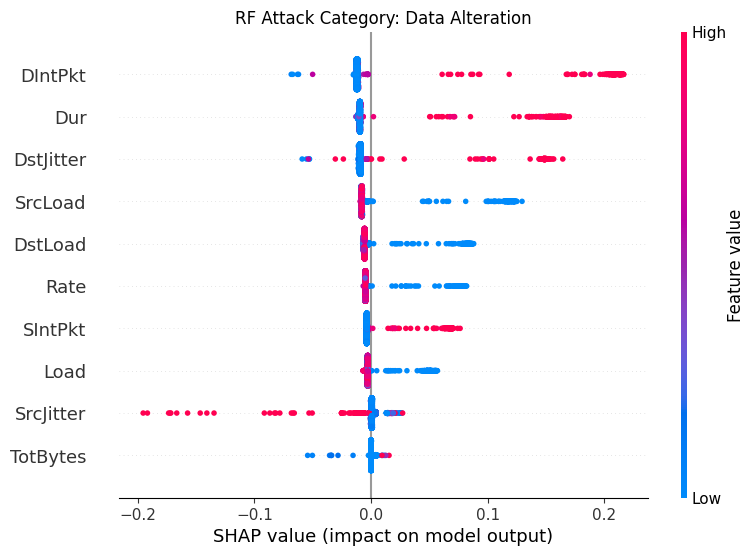

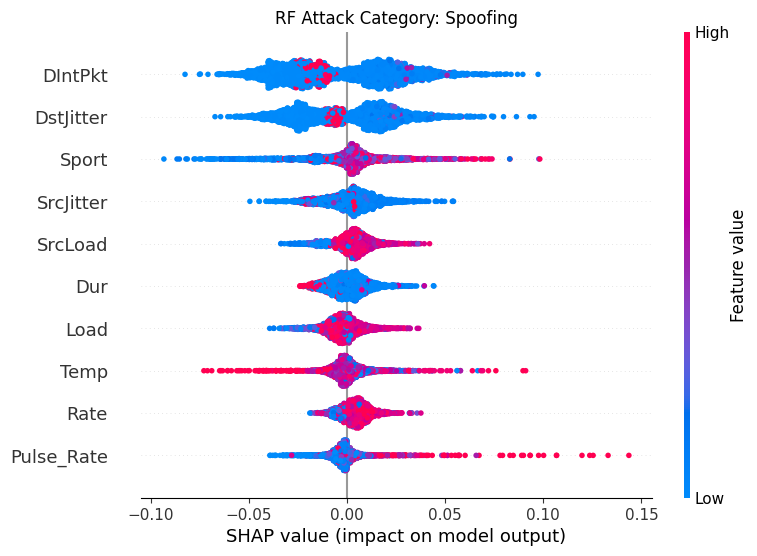

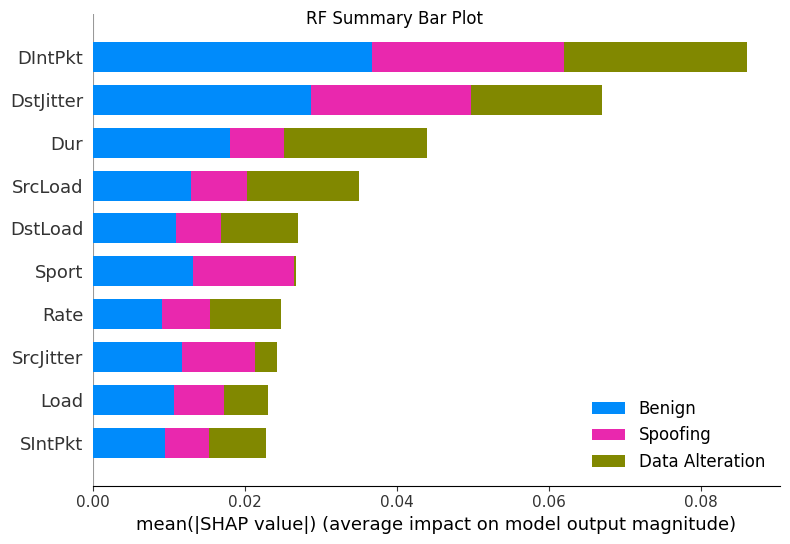

In [ ]:
import shap
explainerRF = shap.Explainer(modelRF)
shap_valuesRF = explainerRF.shap_values(X_testN)

import matplotlib.pyplot as plt
shap.summary_plot(shap_valuesRF[:, :, 0], X_test, show=False, max_display=10)
plt.title("RF Attack Category: Benign")
plt.show()

shap.summary_plot(shap_valuesRF[:, :, 1], X_test, show=False, max_display=10)
plt.title("RF Attack Category: Data Alteration")
plt.show()

shap.summary_plot(shap_valuesRF[:, :, 2], X_test, show=False, max_display=10)
plt.title("RF Attack Category: Spoofing")
plt.show()

def shap_values_to_list(shap_valuesRF, model):
    shap_as_list = []
    for i in range(len(model.classes_)):
        shap_as_list.append(shap_valuesRF[:, :, i])
    return shap_as_list

shap_as_list = shap_values_to_list(shap_valuesRF, modelRF)
shap.summary_plot(shap_as_list, X_test, plot_type="bar", class_names=['Benign', 'Data Alteration', 'Spoofing'], show=False, max_display=10)
plt.suptitle("RF Summary Bar Plot")
plt.show()

### SVM Plots (not tested)

In [ ]:
import shap
explainerSVM = shap.Explainer(modelSVM.predict_proba, X_testN)
shap_valuesSVM = explainerSVM.shap_values(X_testN)

import matplotlib.pyplot as plt
shap.summary_plot(shap_valuesSVM[:, :, 0], X_test, show=False, max_display=10)
plt.title("SVM Attack Category: Benign")
plt.show()

shap.summary_plot(shap_valuesSVM[:, :, 1], X_test, show=False, max_display=10)
plt.title("SVM Attack Category: Data Alteration")
plt.show()

shap.summary_plot(shap_valuesSVM[:, :, 2], X_test, show=False, max_display=10)
plt.title("SVM Attack Category: Spoofing")
plt.show()

def shap_values_to_list(shap_valuesSVM, model):
    shap_as_list = []
    for i in range(len(model.classes_)):
        shap_as_list.append(shap_valuesSVM[:, :, i])
    return shap_as_list

shap_as_list = shap_values_to_list(shap_valuesSVM, modelSVM)
shap.summary_plot(shap_as_list, X_test, plot_type="bar", class_names=['Benign', 'Data Alteration', 'Spoofing'], show=False, max_display=10)
plt.suptitle("SVM Summary Bar Plot")
plt.show()

PermutationExplainer explainer:  54%|█████▎    | 1750/3263 [3:08:55<2:53:26,  6.88s/it]